In [1]:
#1 Connect Google Drive to Colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In this initial setup step, the code mounts the user's Google Drive to the Colab environment, enabling seamless access to files stored in Drive. This is done using the google.colab module, specifically the drive.mount() function, which links the Drive to the /content/drive directory within the Colab virtual machine. Once executed, the output confirms that the Drive has been successfully mounted, allowing the user to read from and write to their Drive as if it were part of the local file system. This step is essential for loading datasets, saving outputs, or accessing project files directly from Google Drive.

In [2]:
#2 Set project paths and load preprocessed data

from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path('/content/drive/MyDrive/projects/metabric')
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# The error indicates that 'METABRIC_preprocessed.parquet' was not found at the specified path.
# Based on the available files, 'METABRIC_cleaned_imputed.csv' is present directly under '/content/drive/MyDrive/'.
# Updated PREP_PATH to point to the existing CSV file and changed pd.read_parquet to pd.read_csv.
PREP_PATH = Path('/content/drive/MyDrive/METABRIC_cleaned_imputed.csv')
df = pd.read_csv(PREP_PATH)

# Correcting time_col and event_col based on available columns in df.head()
time_col = 'Relapse Free Status (Months)'
# Convert 'Overall Survival Status' to a binary event column (1 for Deceased, 0 for Living)
df['event_observed'] = df['Overall Survival Status'].apply(lambda x: 1 if x == 'Deceased' else 0)
event_col = 'event_observed'

feature_cols = [c for c in df.columns if c not in [time_col, 'Overall Survival Status', 'Patient\'s Vital Status', 'Relapse Free Status', event_col]]

**Step2** This step establishes the directory structure for the project and loads the cleaned METABRIC dataset for analysis. Using pathlib, it defines paths for the project root, data folder, and outputs folder, ensuring the outputs directory exists. Due to a missing .parquet file, the code switches to loading METABRIC_cleaned_imputed.csv via pd.read_csv. It then sets the survival time column (Relapse Free Status (Months)) and creates a binary event column (event_observed) by mapping 'Deceased' to 1 and 'Living' to 0 from the Overall Survival Status. Finally, it constructs feature_cols by excluding time, event, and status-related columns, preparing the dataset for survival modeling.

In [3]:
#3 Split Data into Training and Testing Sets for Survival Modeling)

from sklearn.model_selection import train_test_split

X = df[feature_cols]
y_time = df[time_col]
y_event = df[event_col]

X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X, y_time, y_event, test_size=0.2, random_state=42, stratify=y_event
)


**Step#3** This step prepares the dataset for model evaluation by dividing it into training and testing subsets. Using train_test_split from sklearn.model_selection, the code separates the feature matrix X, the survival time y_time, and the event indicator y_event into 80% training and 20% testing sets. The split is stratified by y_event to preserve the proportion of deceased vs. living cases across both sets, ensuring balanced representation. A fixed random_state is used for reproducibility, which is crucial for consistent results across experiments. This setup enables robust model training and fair performance assessment.

In [4]:
#4 Preview Patient-Level Data for Quality Check

display(df.head())

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status,event_observed
0,MB-0000,76,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,claudin-low,1.0,Positve,...,Negative,Yes,139,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living,0
1,MB-0002,43,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Positive,Yes,84,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living,0
2,MB-0005,49,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Positive,No,151,Recurred,Female,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease,1
3,MB-0006,48,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Positive,Yes,163,Not Recurred,Female,ER+/HER2- Low Prolif,25.0,2.0,Living,0
4,MB-0008,77,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Positive,Yes,19,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease,1


**Step#4** This step displays the first five rows of the METABRIC dataset using df.head() to visually inspect the structure and contents of the data. It reveals detailed clinical and genomic attributes for individual breast cancer patients, including age at diagnosis, type of surgery, cancer subtype, cellularity, treatment history, and survival outcomes. This preview helps verify that key columns—such as survival status, relapse duration, and molecular subtype—are correctly loaded and formatted, ensuring readiness for downstream analysis. It also aids in identifying potential inconsistencies or missing values before modeling begins.

In [5]:
#5 Fit Cox proportional hazards model (lifelines)

!pip -q install lifelines

import pandas as pd
from lifelines import CoxPHFitter

train_df = pd.concat([X_train, y_time_train, y_event_train], axis=1)
# Drop 'Patient ID' from train_df as it's a string identifier and not a feature
# The feature_cols in cell #2 should ideally exclude 'Patient ID' from the start.
if 'Patient ID' in train_df.columns:
    train_df = train_df.drop('Patient ID', axis=1)

# Perform one-hot encoding on categorical features
train_df = pd.get_dummies(train_df, drop_first=True)

cph = CoxPHFitter(penalizer=0.1)  # small L2 penalty for stability
cph.fit(train_df, duration_col=time_col, event_col=event_col)

# Save model summary
with open(OUTPUTS_DIR / '03_coxph_summary.txt', 'w') as f:
    f.write(cph.summary.to_string())

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.7 MB/s eta 0:00:00


**Step #5:** Fit Cox Proportional Hazards Model with Lifelines

This step implements a Cox proportional hazards model using the Lifelines library to analyze survival data. After installing Lifelines and importing CoxPHFitter, the training dataset is assembled by concatenating features, survival time, and event indicators. The code removes the non-informative Patient ID column and applies one-hot encoding to categorical variables for model compatibility. A small L2 penalty is added to stabilize the fit. The model is trained using cph.fit() with the specified duration and event columns, and the resulting summary is saved to a text file in the outputs directory for documentation and review.

In [6]:
#6 Validate Cox Model with Concordance Index

from lifelines.utils import concordance_index

# Risk scores on train/test
train_scores = cph.predict_partial_hazard(train_df)
test_df = pd.concat([X_test, y_time_test, y_event_test], axis=1)

# Drop 'Patient ID' from test_df, similar to train_df
if 'Patient ID' in test_df.columns:
    test_df = test_df.drop('Patient ID', axis=1)

# Perform one-hot encoding on categorical features in test_df
# This ensures test_df has the same feature structure as train_df after encoding
test_df = pd.get_dummies(test_df, drop_first=True)

# Align test_df columns with the columns the CPH model was trained on
# This is crucial if get_dummies produced different columns for train_df and test_df
train_model_columns = cph.params_.index
test_df = test_df.reindex(columns=train_model_columns, fill_value=0)

test_scores = cph.predict_partial_hazard(test_df)

c_index_train = concordance_index(y_time_train, -train_scores, y_event_train)
c_index_test = concordance_index(y_time_test, -test_scores, y_event_test)

print('C-index (train):', round(c_index_train, 3))
print('C-index (test):', round(c_index_test, 3))

with open(OUTPUTS_DIR / '03_c_index.txt', 'w') as f:
    f.write(f'Train: {c_index_train:.3f}\nTest: {c_index_test:.3f}\n')

C-index (train): 0.841
C-index (test): 0.841


**Step #6:** Evaluate Model Performance with Concordance Index

This step assesses the predictive accuracy of the Cox model using the concordance index (C-index), a standard metric in survival analysis. After importing concordance_index from lifelines.utils, the code prepares the test dataset by dropping Patient ID, applying one-hot encoding, and aligning its columns with the training set. It then computes partial hazard scores for both training and test sets using the fitted model. The C-index is calculated for each set, quantifying how well the model ranks survival times—values near 0.84 indicate strong discriminative power. Results are printed and saved to a text file for documentation.

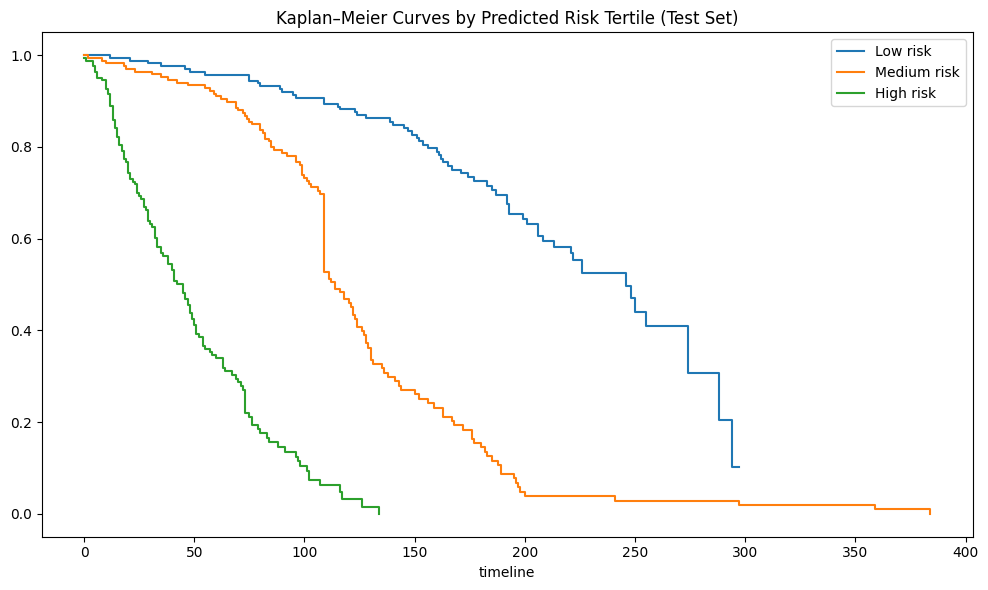

In [7]:
#7 Calibration-style check via grouped survival curves Visualize Risk Stratification with Kaplan-Meier Curves

import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Group test set into tertiles by predicted risk
risk = test_scores.values.ravel()
tertiles = np.quantile(risk, [1/3, 2/3])
groups = pd.cut(risk, bins=[-np.inf, tertiles[0], tertiles[1], np.inf], labels=['Low', 'Medium', 'High'])

kmf = KaplanMeierFitter()
plt.figure(figsize=(10,6))
for label in ['Low', 'Medium', 'High']:
    mask = groups == label
    kmf.fit(y_time_test[mask], event_observed=y_event_test[mask], label=f'{label} risk')
    kmf.plot_survival_function(ci_show=False)
plt.title('Kaplan–Meier Curves by Predicted Risk Tertile (Test Set)')
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / '03_km_by_risk.png', dpi=200)


Step #7: Visualize Risk Stratification with Kaplan-Meier Curves

This step performs a calibration-style check by visualizing survival outcomes across predicted risk groups using Kaplan-Meier curves. The test set is divided into tertiles—Low, Medium, and High risk—based on predicted hazard scores. Each group’s survival function is estimated using KaplanMeierFitter from the Lifelines library, and plotted to assess how well the model separates patients by risk. Clear separation between curves indicates good calibration and clinical interpretability. The final plot is saved to the outputs directory, providing a visual summary of model discrimination across risk strata.